### Imports

In [38]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import os
warnings.filterwarnings("ignore")
import pickle
import json

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split


### Test data extraction & dataframe created

In [2]:

# directory containing the training data
trainDirectory = 'TumourDataSet/Training/'

#  glob to find all files in the training directory, considering all subdirectories
all_files_pattern = os.path.join(trainDirectory, '*/*')
all_file_paths = glob.glob(all_files_pattern)

# Filtering .DS_Store file
filtered_file_paths = [path for path in all_file_paths if not path.endswith('.DS_Store')]

# Extract labels (subdirectory names) from the file paths
extracted_labels = [os.path.basename(os.path.dirname(path)) for path in filtered_file_paths]

# dataframe created directly from the file paths and labels
trainedDataFrame = pd.DataFrame({
    'FilePaths': filtered_file_paths,
    'Labels': extracted_labels
})
# print total number of images
print('Total Number of Images:', trainedDataFrame.shape[0])
trainedDataFrame

Total Number of Images: 5712


FilePaths     Labels
0      TumourDataSet/Training\glioma\Tr-glTr_0000.jpg     glioma
1      TumourDataSet/Training\glioma\Tr-glTr_0001.jpg     glioma
2      TumourDataSet/Training\glioma\Tr-glTr_0002.jpg     glioma
3      TumourDataSet/Training\glioma\Tr-glTr_0003.jpg     glioma
4      TumourDataSet/Training\glioma\Tr-glTr_0004.jpg     glioma
...                                               ...        ...
5707  TumourDataSet/Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  TumourDataSet/Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  TumourDataSet/Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  TumourDataSet/Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  TumourDataSet/Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]

### Test data extraction & dataframe created

In [3]:
# directory containing the training data
testDirectory = 'TumourDataSet/Testing/'

#  glob to find all files in the training directory, considering all subdirectories
all_files_pattern = os.path.join(testDirectory, '*/*')
all_file_paths = glob.glob(all_files_pattern)

# Filtering .DS_Store file
filtered_file_paths = [path for path in all_file_paths if not path.endswith('.DS_Store')]

# Extract labels (subdirectory names) from the file paths
extracted_labels = [os.path.basename(os.path.dirname(path)) for path in filtered_file_paths]

# dataframe created directly from the file paths and labels
testDataFrame = pd.DataFrame({
    'FilePaths': filtered_file_paths,
    'Labels': extracted_labels
})

# print total number of images
print('Total Number of Images:', testDataFrame.shape[0])
testDataFrame

Total Number of Images: 1311


FilePaths     Labels
0      TumourDataSet/Testing\glioma\Te-glTr_0000.jpg     glioma
1      TumourDataSet/Testing\glioma\Te-glTr_0001.jpg     glioma
2      TumourDataSet/Testing\glioma\Te-glTr_0002.jpg     glioma
3      TumourDataSet/Testing\glioma\Te-glTr_0003.jpg     glioma
4      TumourDataSet/Testing\glioma\Te-glTr_0004.jpg     glioma
...                                              ...        ...
1306  TumourDataSet/Testing\pituitary\Te-pi_0295.jpg  pituitary
1307  TumourDataSet/Testing\pituitary\Te-pi_0296.jpg  pituitary
1308  TumourDataSet/Testing\pituitary\Te-pi_0297.jpg  pituitary
1309  TumourDataSet/Testing\pituitary\Te-pi_0298.jpg  pituitary
1310  TumourDataSet/Testing\pituitary\Te-pi_0299.jpg  pituitary

[1311 rows x 2 columns]

### Train, validation, and test sets split and created

In [4]:
# Splitting the original training DataFrame into training and validation sets
trainSet, validSet = train_test_split(trainedDataFrame, test_size=0.2, random_state=42, stratify=trainedDataFrame['Labels'])

# testDataFrame remains as test set for final evaluation
testSet = testDataFrame

### Pixel Intensity for Sample Image

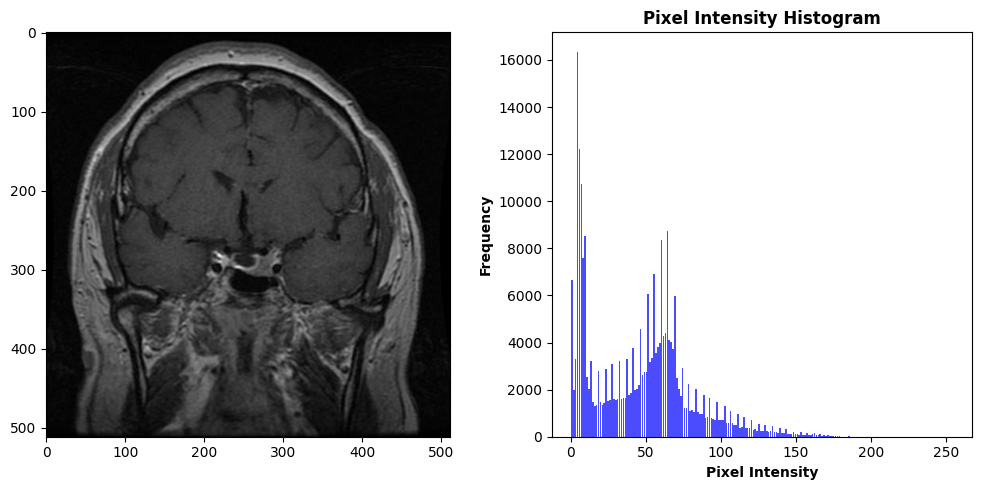

In [30]:

#sample image loaded and converted to an array
sampleImage = Image.open(trainSet['FilePaths'].iloc[14])
sampleImageArray = np.array(sampleImage)


plt.figure(figsize=(10, 5))  

# sample image on the first subplot
plt.subplot(1, 2, 1)  
plt.imshow(sampleImageArray, cmap='gray')
plt.axis('off')  # Hide axis
plt.axis('on')

#  pixel intensity histogram on the second subplot
plt.subplot(1, 2, 2)
plt.hist(sampleImageArray.ravel(), bins=200, color='blue', alpha=0.7, rwidth=0.85)
plt.xlabel('Pixel Intensity', weight = 'bold')
plt.ylabel('Frequency', weight = 'bold')
plt.title('Pixel Intensity Histogram', weight = 'bold')

# figure with both subplots
plt.tight_layout()
plt.show()


### Functions for preprocessing, augmenting, and creating datasets for model

In [6]:

#image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

# Function to read and preprocess the image
def preprocess_image(file_path, label, img_size=IMG_SIZE):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Rescale pixel values and normalize
    return img, label

# function to augment the images
def augment(image, label, img_size=IMG_SIZE):
    image = tf.image.random_flip_left_right(image) # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1) # Random contrast
    image = tf.image.central_crop(image, central_fraction=0.9) # Random crop
    image = tf.image.resize_with_crop_or_pad(image, img_size[0], img_size[1]) # Resize to the original dimensions
    image = tf.clip_by_value(image, 0.0, 1.0) # Clip values
    return image, label

# Function to create a dataset from a DataFrame
def create_dataset(df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, training=True):
    paths = df['FilePaths'].values
    labels = pd.get_dummies(df['Labels']).values  # One-hot encode labels
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: augment(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

### Train, Validation, and Test set generators created for model

In [7]:
trainGeneration = create_dataset(trainSet, BATCH_SIZE, IMG_SIZE, training=True) # Training set for the model
validGeneration = create_dataset(validSet, BATCH_SIZE, IMG_SIZE, training=False) # Validation set for the model
testGeneration = create_dataset(testSet,BATCH_SIZE, IMG_SIZE, training=False) # Test set for the final evaluation

### Image count for each set and each tumour type in each set

In [23]:
def countClass(df, label_col='Labels'):
    class_counts = df[label_col].value_counts()
    return class_counts

# Count occurrences for each set
trainClassCount = countClass(trainSet)
validClassCount = countClass(validSet)
testClassCount = countClass(testSet)

def printSummary(df_name, df, class_counts):
    print(f"Found {len(df)} validated image filenames belonging to {len(class_counts)} classes in the {df_name} set.")
    for class_label, count in class_counts.items():
        print(f" - {class_label}: {count} images")

printSummary("training", trainSet, trainClassCount)
printSummary("validation", validSet, validClassCount)
printSummary("testing", testSet, testClassCount)


Found 4569 validated image filenames belonging to 4 classes in the training set.
 - notumor: 1276 images
 - pituitary: 1165 images
 - meningioma: 1071 images
 - glioma: 1057 images
Found 1143 validated image filenames belonging to 4 classes in the validation set.
 - notumor: 319 images
 - pituitary: 292 images
 - meningioma: 268 images
 - glioma: 264 images
Found 1311 validated image filenames belonging to 4 classes in the testing set.
 - notumor: 405 images
 - meningioma: 306 images
 - glioma: 300 images
 - pituitary: 300 images


### Class distribution across the training and test sets

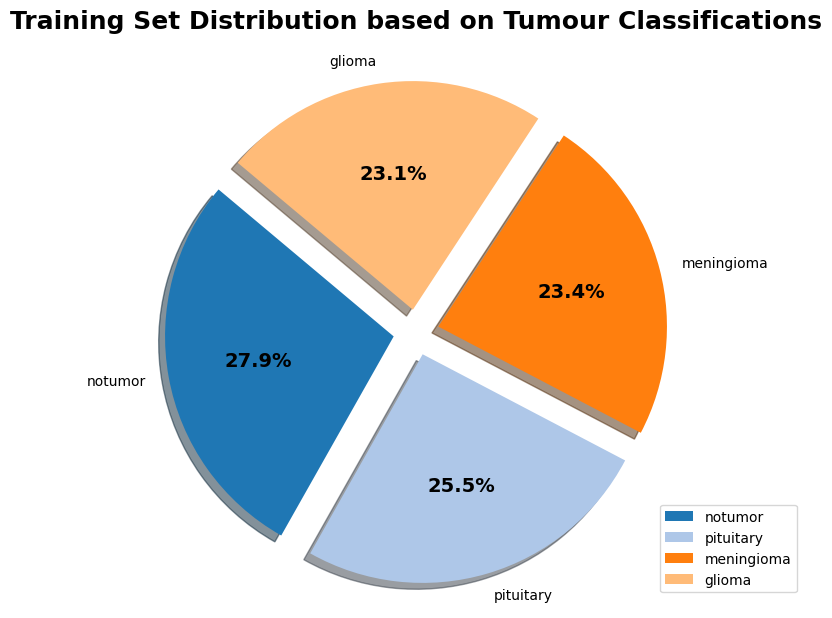

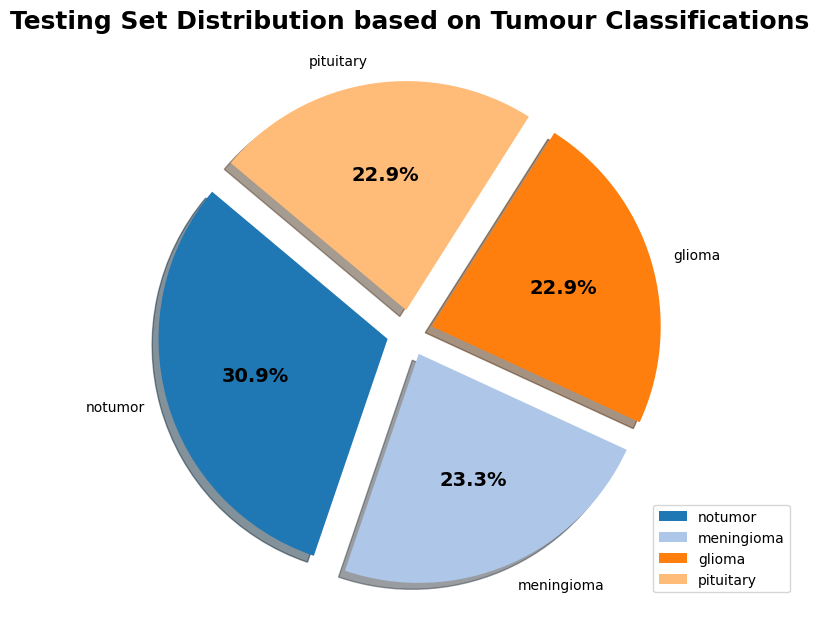

In [25]:
def plotPieChart(df, title):
    class_counts = countClass(df)
    colors = plt.get_cmap('tab20').colors  # colormap for a nice set of colors
    explode = [0.1] * len(class_counts)  # Exploding all slices a bit

    # pie chart with additional space between the title and the chart
    fig, ax = plt.subplots(figsize=(10, 8))
    patches, texts, autotexts = ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
                                        startangle=140, colors=colors, explode=explode, shadow=True)

    # font size of the autopct and make it bold
    for autotext in autotexts:
        autotext.set_fontsize(14)  # Larger font for the percentages
        autotext.set_fontweight('bold')  # Bold font for the percentages

   
    plt.title(title, fontsize=18, fontweight='bold', pad=20)

    
    plt.subplots_adjust(top=0.8)

    # legend with a tight bounding box
    plt.legend(patches, class_counts.index, loc="best", bbox_to_anchor=(0.9, 0.1, 0.1, 0.1))

   
    plt.axis('equal')
    plt.show()

# pie charts created for the training and testing sets
plotPieChart(trainSet, 'Training Set Distribution based on Tumour Classifications')
plotPieChart(testSet, 'Testing Set Distribution based on Tumour Classifications')


### Sample Images from training set

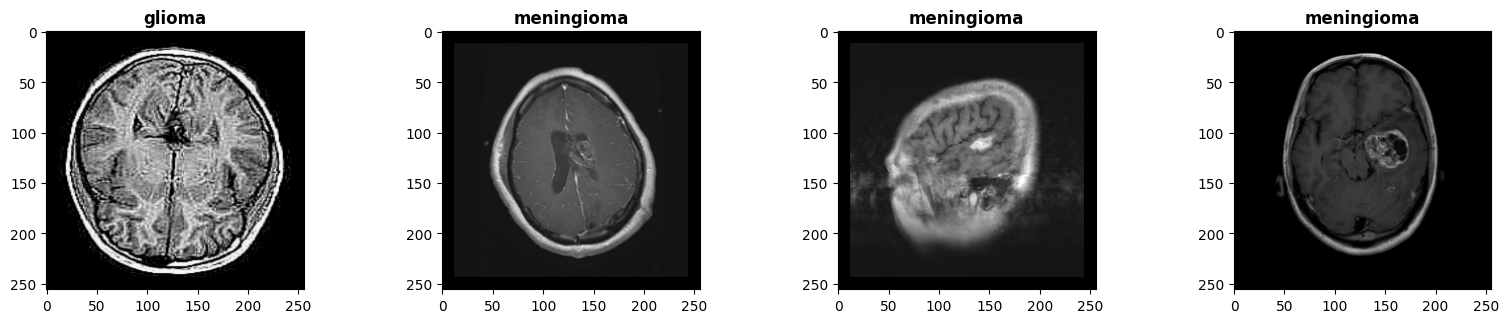

In [26]:
# display sample of images and their classes

classes = list(trainSet['Labels'].unique()) # List of unique classes
images, labels = next(iter(trainGeneration)) # Get a batch of images and labels

imageArray = [] # Empty list to store images

plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)

    imageArray.append(image)

    index = np.argmax(labels[i])
    className = classes[index] 
    plt.title(className, color = 'black', fontsize = 12, weight = 'bold')
    plt.axis('on')
    plt.grid(False)
    plt.gca().set_facecolor('#0a0a23')

plt.tight_layout()
plt.show()


### Deep Neural Network (CNN) Design

In [10]:

inputShape = (256, 256, 3) # Image shape
numberOfClasses = len(trainSet['Labels'].unique()) # Number of classes

trainedModel = Sequential([
    # First convolutional block
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=inputShape),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Added dropout layer for regularization

    # Second convolutional block
    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),  # Added dropout layer for regularization

    # Third convolutional block
    Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # Added dropout layer for regularization


    # Fourth convolutional block
    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # Added dropout layer for regularization

    # Fifth convolutional block
    Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),  # Added dropout layer for regularization

    # Flattening the convolutions
    Flatten(),

    # Fully connected layer
    Dense(units=256),
    BatchNormalization(),
    Activation('relu'), # ReLU activation function
    Dropout(0.5),

    # Output layer
    Dense(units=numberOfClasses, activation='softmax') # Softmax activation function
])

#model compiled
trainedModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer and categorical crossentropy loss function

#summary of the model
trainedModel.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,963,460 (38.01 MB)

 Trainable params: 9,960,964 (38.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

### Training the model on the train set generator

In [11]:
trainingHistory = trainedModel.fit(trainGeneration, validation_data=validGeneration, epochs=20)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 254s 872ms/step - accuracy: 0.6156 - loss: 0.9658 - val_accuracy: 0.2310 - val_loss: 2.9266
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 249s 868ms/step - accuracy: 0.7662 - loss: 0.5969 - val_accuracy: 0.6299 - val_loss: 0.9845
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 255s 887ms/step - accuracy: 0.8231 - loss: 0.4613 - val_accuracy: 0.5459 - val_loss: 2.3942
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 253s 882ms/step - accuracy: 0.8616 - loss: 0.3643 - val_accuracy: 0.9020 - val_loss: 0.2680
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 255s 889ms/step - accuracy: 0.8881 - loss: 0.3028 - val_accuracy: 0.8968 - val_loss: 0.3059
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 256s 891ms/step - accuracy: 0.9025 - loss: 0.2748 - val_accuracy: 0.7830 - val_loss: 0.6531
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 253s 881ms/step - accuracy: 0.9132 - loss: 0.2413 - val_accuracy: 0.9186 - val_loss: 0.2284
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 251s 876ms/step - accuracy: 0.9184 -

### Training history saved

In [12]:
with open('training_history.pickle', 'wb') as handle:
    pickle.dump(trainingHistory.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Training history saved

In [13]:
# Convert the training history to a JSON string
history_json = json.dumps(trainingHistory.history)

# Write the JSON string to a file
with open('training_history.json', 'w') as f:
    f.write(history_json)

### CNN model saved

In [14]:
trainedModel.save('BrainTumourClassificationModel.h5')

### Model evaluation on test set generator

In [15]:
loss, accuracy = trainedModel.evaluate(testGeneration)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy * 100, '%')

82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.9597 - loss: 0.1425
Test Loss: 0.11658351123332977
Test Accuracy: 96.6437816619873 %
